# SUP ML 2 - MODEL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importamos Librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import graphviz

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")


In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.4 MB/s eta 0:00:00


In [5]:
# preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# algoritmos de clasificación
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# algoritmos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# metricas
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Carga clean data

In [6]:
df_train = pd.read_pickle("/content/drive/MyDrive/NUCLIO/DSC032024_Entregable2_Alves_Asaro_Garcia_Moreno/final_df.pkl")

In [7]:
target = 'churn'

In [8]:
# En este caso de clasificación, el target es booleano (True/False)
df_train[target] = df_train[target].astype('bool')

### Para ver todas las columnas

In [9]:
features = [i for i in df_train.columns if i != target]

In [10]:
features

['rev',
 'mou',
 'totmrc',
 'da',
 'ovrmou',
 'ovrrev',
 'vceovr',
 'datovr',
 'roam',
 'change_mou',
 'change_rev',
 'drop_vce',
 'drop_dat',
 'blck_vce',
 'blck_dat',
 'unan_vce',
 'unan_dat',
 'plcd_vce',
 'plcd_dat',
 'recv_vce',
 'recv_sms',
 'comp_vce',
 'comp_dat',
 'custcare',
 'ccrndmou',
 'cc_mou',
 'inonemin',
 'threeway',
 'mou_cvce',
 'mou_cdat',
 'mou_rvce',
 'owylis_vce',
 'mouowylisv',
 'iwylis_vce',
 'mouiwylisv',
 'peak_vce',
 'peak_dat',
 'mou_peav',
 'mou_pead',
 'opk_vce',
 'opk_dat',
 'mou_opkv',
 'mou_opkd',
 'drop_blk',
 'attempt',
 'complete',
 'callfwdv',
 'callwait',
 'months',
 'uniqsubs',
 'actvsubs',
 'asl_flag',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou',
 'avg3qty',
 'avg3rev',
 'avg6mou',
 'avg6qty',
 'avg6rev',
 'refurb_new',
 'hnd_price',
 'phones',
 'models',
 'hnd_webcap',
 'truck',
 'rv',
 'ownrent',
 'lor',
 'dwlltype',
 'adults',
 'income',
 'numbcars',
 'forgntvl',
 'kid0_2',
 

# Split X-y

In [11]:
y = df_train[target]
X = df_train[features]

# Distribución del target

In [12]:
# Distribucion en %
y.value_counts(normalize=True)


churn
True     0.509487
False    0.490513
Name: proportion, dtype: float64

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

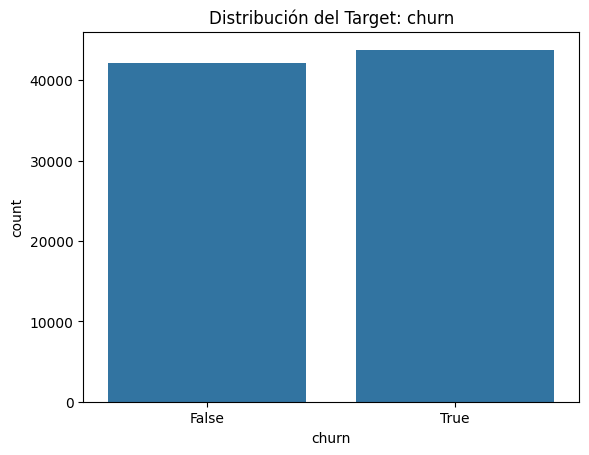

In [13]:
sns.countplot(x=y)
plt.title('Distribución del Target: '+target) #Notamos que la target está balanceada
plt.show()

# Split TRAIN-TEST

In [14]:
# Se guarda un 30% de datos para el test y un 70% para el train
y = df_train['churn']
X = df_train.drop('churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [15]:
# Hemos realizado ya el rescaling mediante la técnica de MinMaxScaler en ML 1 - Preprocessing, por lo tanto no es necesario hacer rescaling en ML 2 - Model

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [16]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)
  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [17]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""
  # creamos la lista de auc vacía
  lista_aucs = []
  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)
  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))
  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)
  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))
  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)
  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))
  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)
  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))
  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)
  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))
  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)
  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))
  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)
  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))
  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)
  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))
  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')
  return df_aucs

## AUC gráficamente

Support Vector Machine


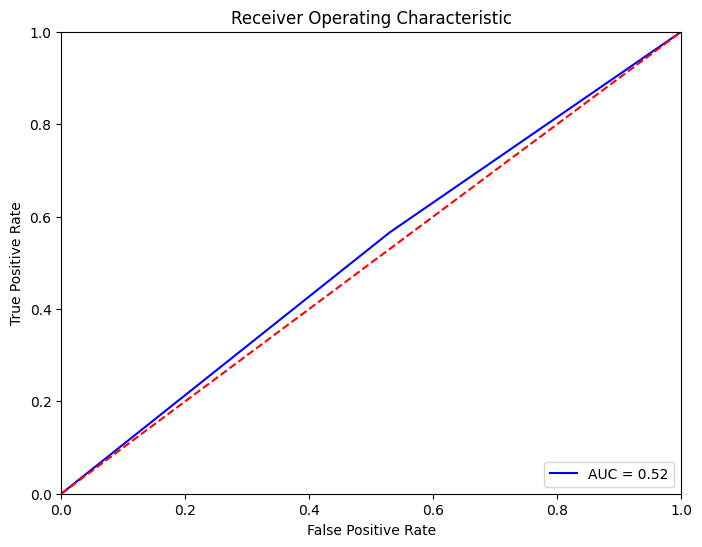

Regresión logística


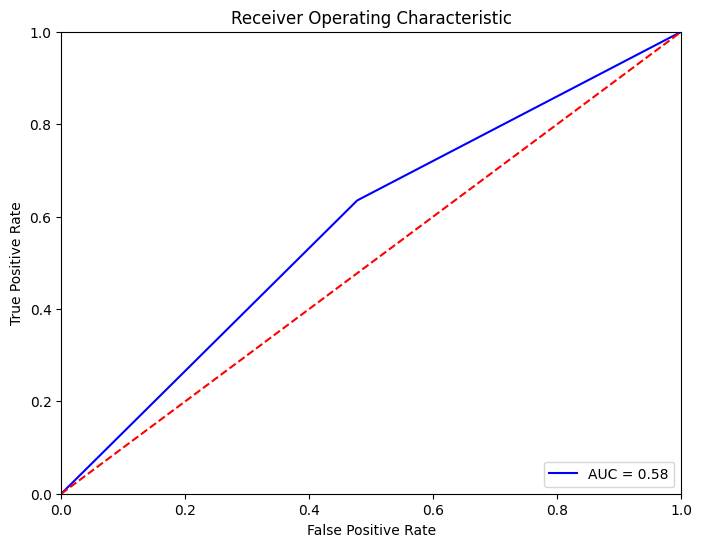

RidgeClassifier


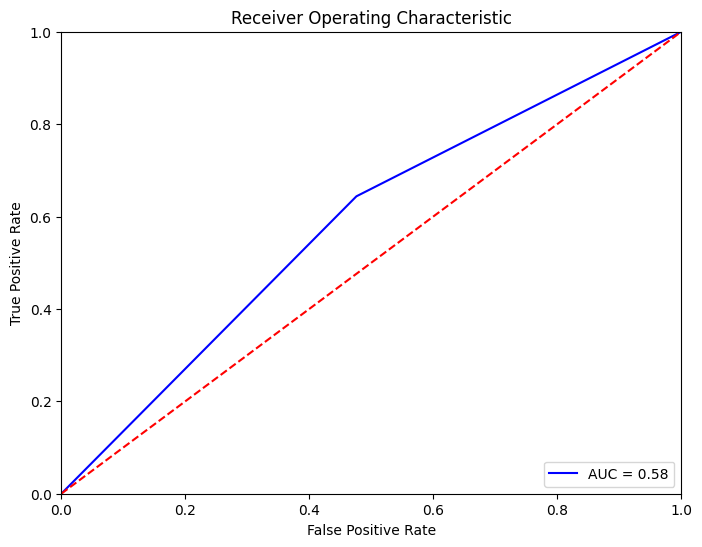

Decision tree classsifier


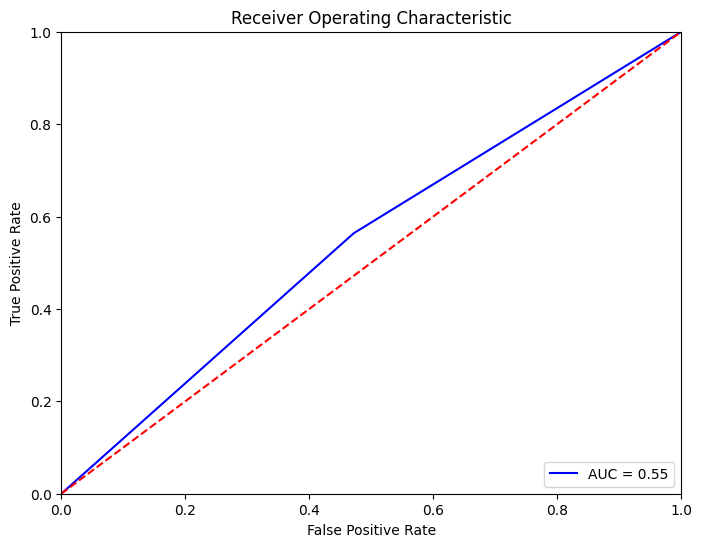

Random forest


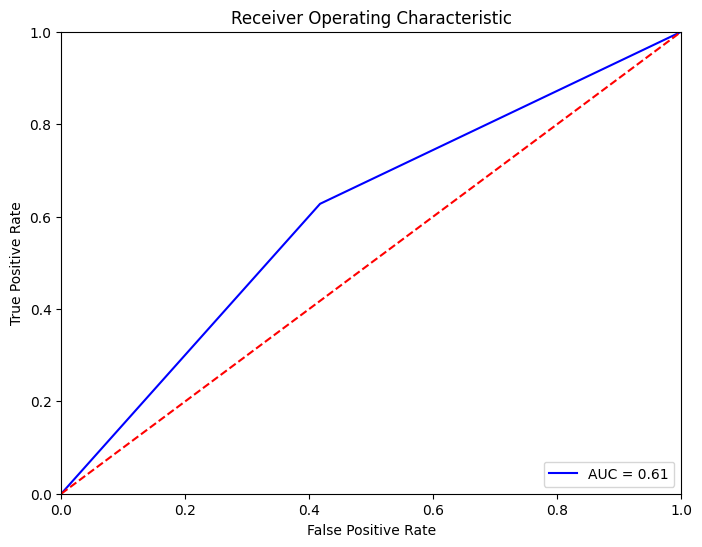

Gradient boosting


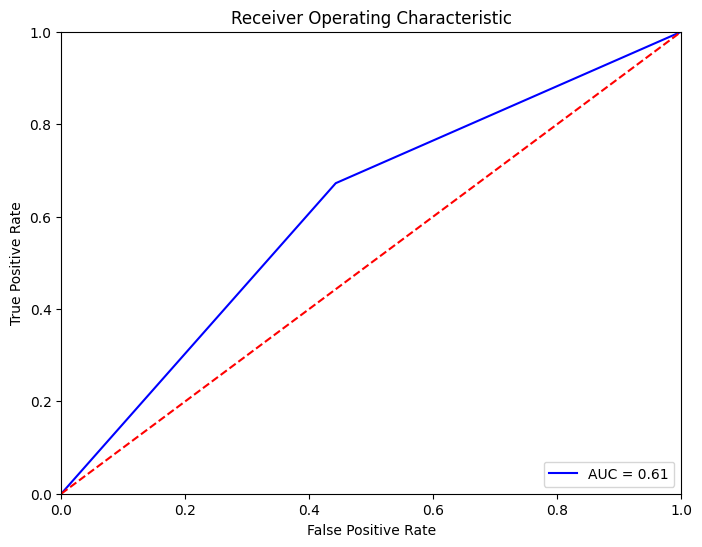

XGBClassifier


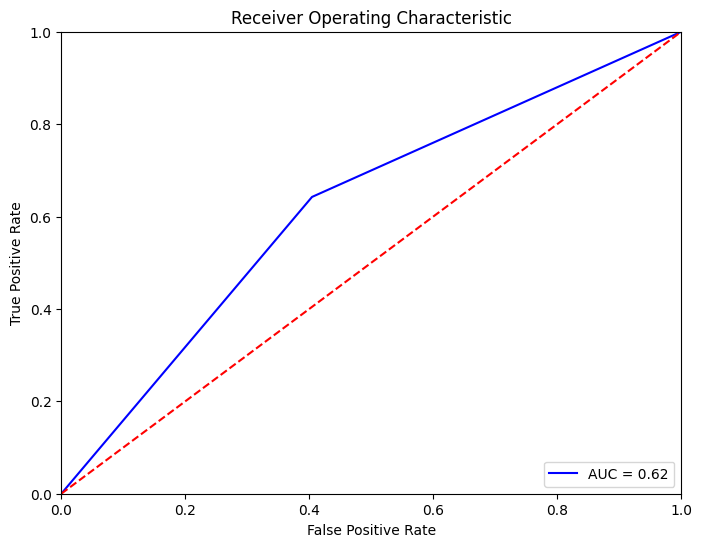

CatBoostClassifier


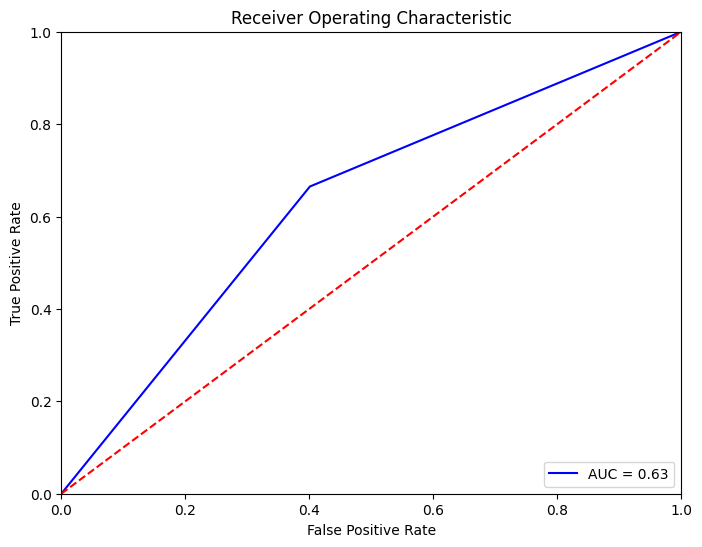

In [18]:
aucs = entrenar(X_train, X_test, y_train, y_test)

## Lista de AUC, ordenada

In [19]:
aucs.sort_values(by='AUC',ascending = False)

,AUC
modelos,
CatBoost Classifier,0.63197
XGB classifier,0.61899
gradient boosting,0.61474
random forest,0.60505
RidgeClassifier,0.58386
regresión logística,0.57875
decision tree classifier,0.54606
SVC,0.51793


In [20]:
# Lista de modelos
modelos = [
    ('RF', RandomForestClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False)),
    ('DecisionTreeClassifier', DecisionTreeClassifier())]

metricas = pd.DataFrame({'modelo':[], 'f1_score':[]})

for nombre, modelo in modelos:
  # entrenamiento
  modelo.fit(X_train, y_train)

  y_pred = modelo.predict(X_test)

  # evalua la metrica
  f1_score = metrics.f1_score(y_test, y_pred, average='macro')

  # añade la métrica al dataframe de métricas
  metricas = metricas._append({'modelo':nombre, 'f1_score':f1_score}, ignore_index = True)

  print(nombre, np.round(f1_score,5))

RF 0.60519
LR 0.57953
KNN 0.5139
NB 0.46938
CatBoostClassifier 0.63053
DecisionTreeClassifier 0.54546


## Lista F1 Score, ordenada

In [21]:
metricas.sort_values(by='f1_score', ascending = False)

,modelo,f1_score
4,CatBoostClassifier,0.630530
0,RF,0.605188
1,LR,0.579532
5,DecisionTreeClassifier,0.545459
2,KNN,0.513896
3,NB,0.469377


## Hiperparametrización

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [22]:
# Opciones de búsqueda de los parámetros
param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'scale_pos_weight': [1, 2, 3]
}

In [23]:
# Crear el modelo CatBoostClassifier
model = CatBoostClassifier(
    loss_function='Logloss', # Función de pérdida
    eval_metric='Accuracy', # Métrica de evaluación
    random_seed=42, # Semilla aleatoria para reproducibilidad
    verbose=100 # Mostrar logs cada 100 iteraciones
)

In [24]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    scoring='accuracy',
    cv=3,  # Validación cruzada con 3 particiones
    random_state=42,
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.5774587	total: 51.7ms	remaining: 51.6s
100:	learn: 0.6249211	total: 5.07s	remaining: 45.2s
200:	learn: 0.6415894	total: 12.4s	remaining: 49.2s
300:	learn: 0.6556320	total: 15.8s	remaining: 36.7s
400:	learn: 0.6678798	total: 19.1s	remaining: 28.6s
500:	learn: 0.6796125	total: 24s	remaining: 23.9s
600:	learn: 0.6896833	total: 29.1s	remaining: 19.3s
700:	learn: 0.6995380	total: 32.5s	remaining: 13.9s
800:	learn: 0.7081131	total: 35.8s	remaining: 8.89s
900:	learn: 0.7159238	total: 41.2s	remaining: 4.52s
999:	learn: 0.7241666	total: 45.7s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7b7466566e60>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [500, 1000, 1500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'scale_pos_weight': [1, 2, 3]},
                   random_state=42, scoring='accuracy', verbose=1)

In [25]:
# Obtener los mejores hiperparámetros
best_params = random_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'scale_pos_weight': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 6, 'border_count': 64}


## Modelo final
* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [26]:
# Cargar el modelo guardado si existe
try:
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
except FileNotFoundError:
    best_model = None

In [27]:
# Entrenar el mejor modelo
if(not best_model):
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.5774587	test: 0.5693901	best: 0.5693901 (0)	total: 61.6ms	remaining: 1m 1s
100:	learn: 0.6249211	test: 0.6145256	best: 0.6147582 (99)	total: 3.7s	remaining: 32.9s
200:	learn: 0.6415894	test: 0.6216992	best: 0.6223971 (197)	total: 7.19s	remaining: 28.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6223971461
bestIteration = 197

Shrink model to first 198 iterations.


In [28]:
# Predecir en los datos de prueba
y_pred = best_model.predict(X_test)

# TEST
* Evaluación de las métricas de performance en TEST.

In [29]:
# Evaluar el mejor modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6223971460700298
Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.57      0.60     12621
        True       0.62      0.68      0.65     13168

    accuracy                           0.62     25789
   macro avg       0.62      0.62      0.62     25789
weighted avg       0.62      0.62      0.62     25789

Confusion Matrix:
[[7157 5464]
 [4274 8894]]


# INTERPRETABILITY
* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

In [30]:
# Obtener las características más importantes del modelo CatBoost
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

# Crear un DataFrame con las características y sus importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [31]:
# Ordenar las características por su importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df.head(5))

       Feature  Importance
48      months   15.687325
87     eqpdays   11.925407
1          mou    7.766261
9   change_mou    7.726822
68   hnd_price    4.303224


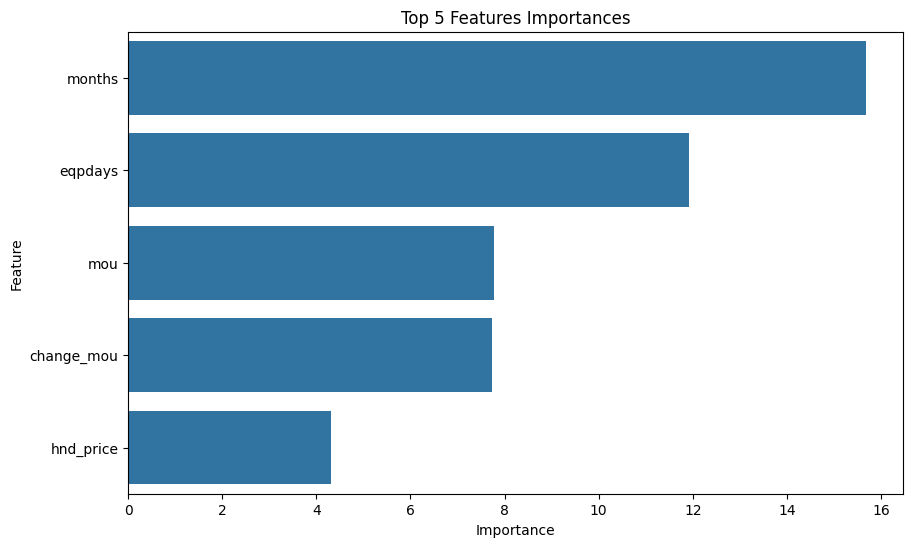

In [32]:
# Graficar las principales características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(5))
plt.title('Top 5 Features Importances')
plt.show()

In [34]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.5 MB/s eta 0:00:00


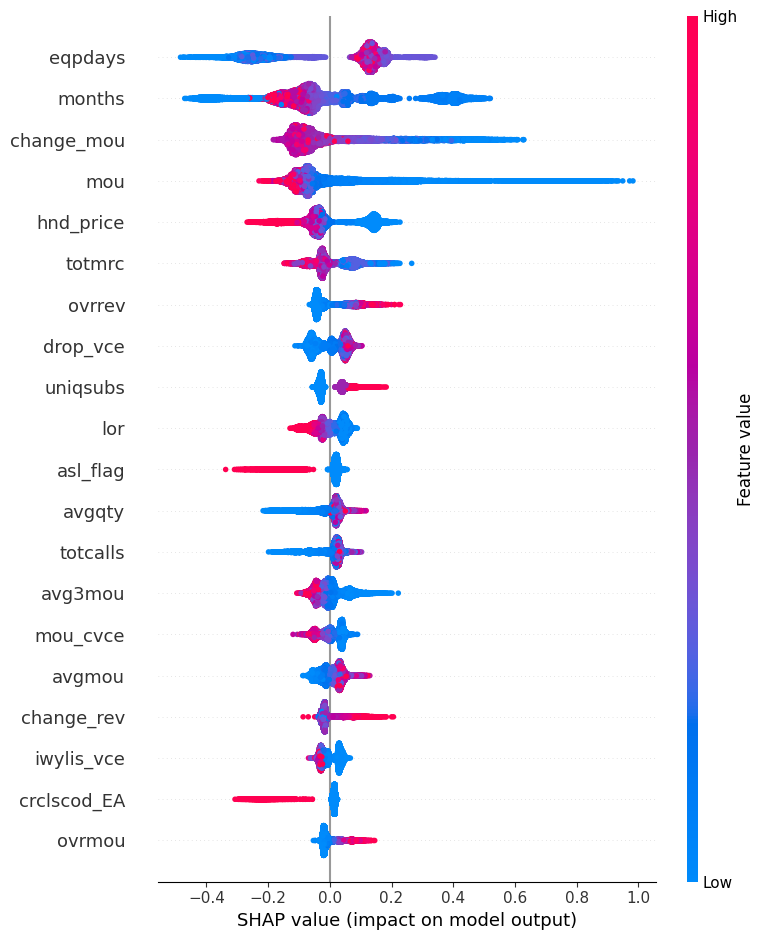

In [36]:
import shap

# Crear un objeto de valores SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Graficar los valores SHAP
#shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.summary_plot(shap_values, X_test)

In [37]:
top5_features = feature_importances_df.head(5)['Feature'].values
top5_features

array(['months', 'eqpdays', 'mou', 'change_mou', 'hnd_price'],
      dtype=object)

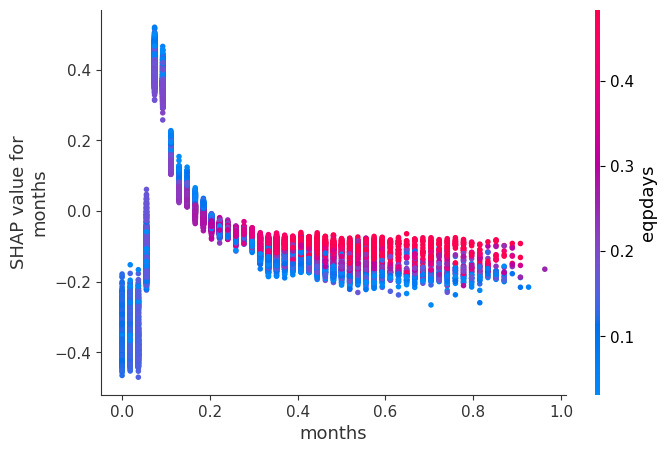

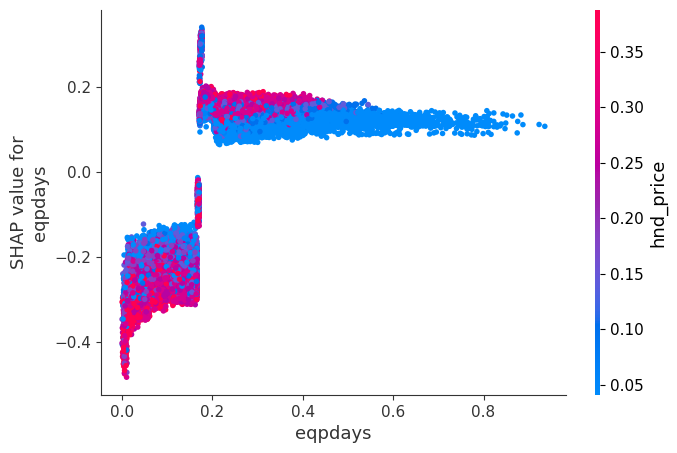

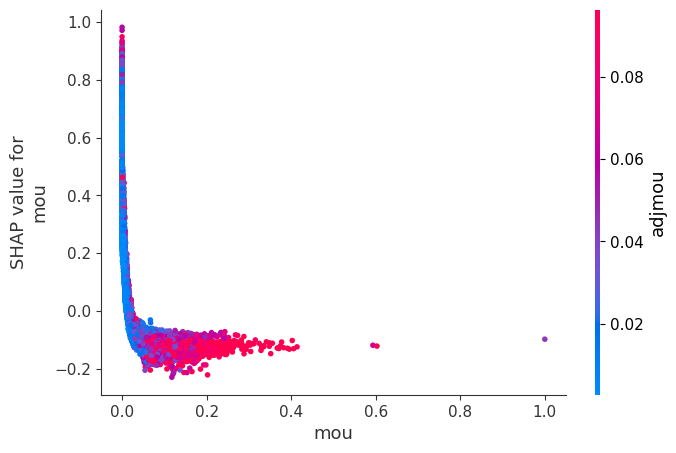

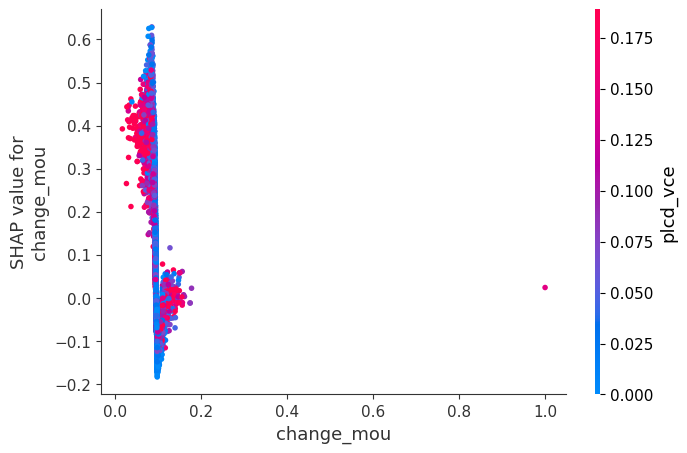

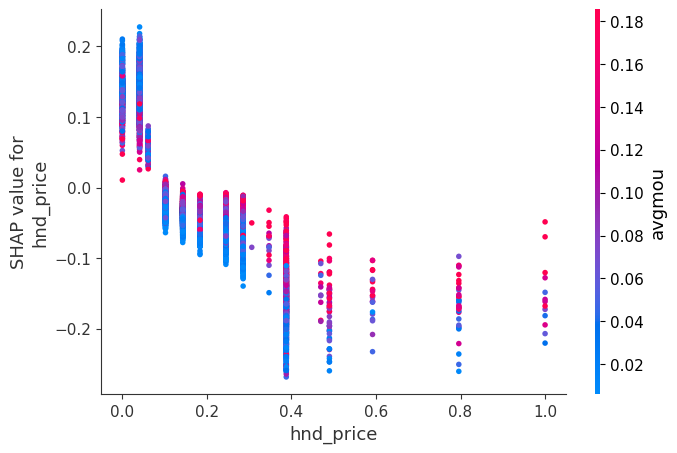

In [38]:
for feature in top5_features:
    shap.dependence_plot(feature, shap_values, X_test)

### Comentarios sobre las 5 características principales

1. **`months`**:
   - **Impacto**: Los clientes que han estado en el servicio por más meses tienden a tener una menor probabilidad de churn.
   - **Insight**: La retención mejora con la duración del servicio; los clientes a largo plazo están más comprometidos.

2. **`eqpdays`**:
   - **Impacto**: El número de días que el cliente ha tenido su equipo actual tiene una relación inversa con el churn.
   - **Insight**: Los clientes con equipos más nuevos pueden estar más satisfechos con su experiencia y menos propensos a abandonar el servicio.

3. **`change_mou`**:
   - **Impacto**: Un cambio significativo en los minutos de uso mensual en comparación con el promedio de los tres meses anteriores puede indicar un aumento en la insatisfacción o un cambio en el comportamiento del cliente.
   - **Insight**: Monitorear cambios abruptos en el uso puede ayudar a identificar clientes en riesgo de churn.

4. **`mou`**:
   - **Impacto**: El número promedio de minutos de uso mensual muestra una relación directa con la retención; mayor uso está asociado con menor churn.
   - **Insight**: Fomentar el uso del servicio puede contribuir a la retención de clientes.

5. **`totmrc`**:
   - **Impacto**: El cargo mensual recurrente total también influye en la retención; cargos más altos pueden estar relacionados con servicios adicionales que mantienen a los clientes satisfechos.
   - **Insight**: Clientes que pagan más por servicios adicionales pueden estar más satisfechos y menos propensos a cambiar de proveedor.

### Análisis complementarios

#### Modelos de árboles: plot de árbol de decisión

In [43]:
pip install graphviz

In [51]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train[top5_features], y_train)

dot_data = export_graphviz(dt_model, out_file=None,
      feature_names=top5_features,
      class_names=['No churn', 'Churn'],
      filled=True, rounded=True,
      special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree") # Esto creará un archivo llamado decision_tree.pdf con la representación del árbol

'decision_tree.pdf'

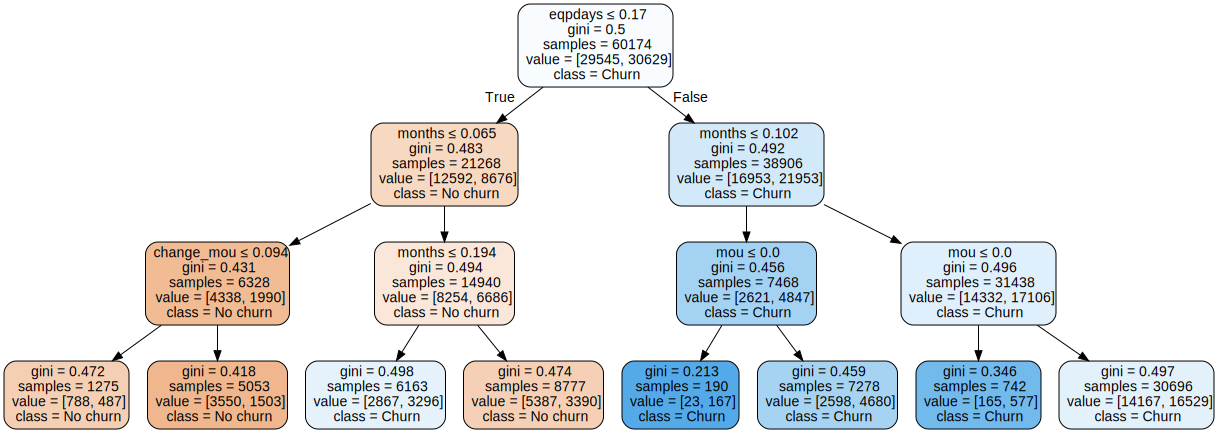

In [50]:
graphviz.Source(dot_data)

#### Modelos lineales: Coeficientes y fórmula del modelo

In [42]:
# Para los modelos lineales, como una regresión logística, obtendremos los coeficientes y formularemos el modelo:
from sklearn.linear_model import LogisticRegression

# Ajustar un modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Obtener los coeficientes del modelo y features
coefficients = log_reg.coef_[0]
features = X_train.columns

# Array de coeficientes y features, y ordenar por la magnitud de los coeficientes
coef_feature_pairs = sorted(zip(np.abs(coefficients), coefficients, features), reverse=True)

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df.head(10))

       Feature  Coefficient
59      avgmou     3.812273
49    uniqsubs     2.557967
6       vceovr     2.541370
5       ovrrev     2.219348
87     eqpdays     1.964565
4       ovrmou     1.477991
11    drop_vce     1.344776
60      avgqty     1.284572
0          rev     1.255492
10  change_rev     1.131495


In [46]:
# Fórmula del modelo ordenada por la importancia de las características
formula = ' + '.join([f'{coef:+.2f} * {feat}' for _, coef, feat in coef_feature_pairs])
print('Model Formula:')
print(f'churn = {log_reg.intercept_[0]:.2f} + {formula}')

Model Formula:
churn = 0.38 + -5.13 * mou + -4.28 * change_mou + +3.81 * avgmou + +2.56 * uniqsubs + +2.54 * vceovr + +2.22 * ovrrev + +1.96 * eqpdays + -1.80 * avg3mou + -1.76 * threeway + +1.48 * ovrmou + -1.36 * adjrev + +1.34 * drop_vce + +1.28 * avgqty + +1.26 * rev + +1.13 * change_rev + -1.08 * months + -1.00 * opk_vce + -0.99 * peak_vce + +0.98 * roam + +0.96 * avgrev + -0.93 * totmrc + +0.90 * drop_blk + +0.89 * totmou + +0.84 * da + +0.78 * phones + +0.76 * avg6qty + -0.76 * iwylis_vce + -0.68 * totrev + -0.67 * ccrndmou + +0.66 * adjmou + +0.66 * recv_sms + -0.65 * avg3qty + -0.62 * hnd_price + +0.61 * mouiwylisv + -0.60 * mou_peav + +0.60 * models + -0.54 * recv_vce + -0.51 * avg6mou + +0.46 * mou_opkv + -0.42 * cc_mou + +0.41 * datovr + -0.35 * ethnic_Z + -0.35 * adjqty + -0.34 * mou_cvce + +0.33 * mou_pead + -0.31 * drop_dat + +0.31 * ethnic_O + -0.29 * crclscod_EA + +0.27 * area_NORTHWEST/ROCKY MOUNTAIN AREA + +0.26 * blck_dat + +0.25 * blck_vce + +0.25 * plcd_vce + -0.2

### Guardar los resultados

In [47]:
# Guardar el modelo entrenado
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)